# 1. Read the file

In [2]:
import pandas as pd
df = pd.read_csv('train.csv')
df.head()

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales
0,FDA15,9.30,Low Fat,0.016047,Dairy,249.8092,OUT049,1999,Medium,Tier 1,Supermarket Type1,3735.1380
1,DRC01,5.92,Regular,0.019278,Soft Drinks,48.2692,OUT018,2009,Medium,Tier 3,Supermarket Type2,443.4228
2,FDN15,17.50,Low Fat,0.016760,Meat,141.6180,OUT049,1999,Medium,Tier 1,Supermarket Type1,2097.2700
3,FDX07,19.20,Regular,0.000000,Fruits and Vegetables,182.0950,OUT010,1998,NaN,Tier 3,Grocery Store,732.3800
4,NCD19,8.93,Low Fat,0.000000,Household,53.8614,OUT013,1987,High,Tier 3,Supermarket Type1,994.7052


In [7]:
df.shape

(8523, 36)

# 2. Impute missing values

In [3]:
df.isnull().sum()

Item_Identifier                 0
Item_Weight                  1463
Item_Fat_Content                0
Item_Visibility                 0
Item_Type                       0
Item_MRP                        0
Outlet_Identifier               0
Outlet_Establishment_Year       0
Outlet_Size                  2410
Outlet_Location_Type            0
Outlet_Type                     0
Item_Outlet_Sales               0
dtype: int64

In [4]:
#missing values in Item_weight and Outlet_size needs to be imputed
mean = df['Item_Weight'].mean() #imputing item_weight with mean
df['Item_Weight'].fillna(mean, inplace =True)

mode = df['Outlet_Size'].mode() #imputing outlet size with mode
df['Outlet_Size'].fillna(mode[0], inplace =True)

# 3. Deal with categorical variables and drop the id columns

In [5]:
df.drop(['Item_Identifier', 'Outlet_Identifier'], axis=1, inplace=True)
df = pd.get_dummies(df)

# 4. Create train and test set

In [8]:
from sklearn.model_selection import train_test_split
train , test = train_test_split(df, test_size = 0.3)

x_train = train.drop('Item_Outlet_Sales', axis=1)
y_train = train['Item_Outlet_Sales']

x_test = test.drop('Item_Outlet_Sales', axis = 1)
y_test = test['Item_Outlet_Sales']

# 5. Preprocessing – Scaling the features

In [9]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0, 1))

x_train_scaled = scaler.fit_transform(x_train)
x_train = pd.DataFrame(x_train_scaled)

x_test_scaled = scaler.fit_transform(x_test)
x_test = pd.DataFrame(x_test_scaled)

# 6. Let us have a look at the error rate for different k values

In [10]:
#import required packages
from sklearn import neighbors
from sklearn.metrics import mean_squared_error 
from math import sqrt
import matplotlib.pyplot as plt
%matplotlib inline

In [11]:
rmse_val = [] #to store rmse values for different k
for K in range(20):
    K = K+1
    model = neighbors.KNeighborsRegressor(n_neighbors = K)

    model.fit(x_train, y_train)  #fit the model
    pred=model.predict(x_test) #make prediction on test set
    error = sqrt(mean_squared_error(y_test,pred)) #calculate rmse
    rmse_val.append(error) #store rmse values
    print('RMSE value for k= ' , K , 'is:', error)

RMSE value for k=  1 is: 1580.988587282693
RMSE value for k=  2 is: 1380.372900633955
RMSE value for k=  3 is: 1324.7773964416854
RMSE value for k=  4 is: 1295.976946810279
RMSE value for k=  5 is: 1279.297869467596
RMSE value for k=  6 is: 1267.7548200409253
RMSE value for k=  7 is: 1259.7580342230874
RMSE value for k=  8 is: 1264.2925192848402
RMSE value for k=  9 is: 1262.4326650926018
RMSE value for k=  10 is: 1262.0750419892772
RMSE value for k=  11 is: 1261.0781117434447
RMSE value for k=  12 is: 1262.080591462001
RMSE value for k=  13 is: 1267.260066896
RMSE value for k=  14 is: 1271.6306802668003
RMSE value for k=  15 is: 1277.1639616507919
RMSE value for k=  16 is: 1285.2555747965541
RMSE value for k=  17 is: 1289.8375010083175
RMSE value for k=  18 is: 1294.9686328807584
RMSE value for k=  19 is: 1301.3138702725196
RMSE value for k=  20 is: 1306.709269726239


<AxesSubplot:>

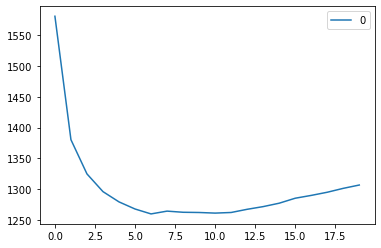

In [12]:
#plotting the rmse values against k values
curve = pd.DataFrame(rmse_val) #elbow curve 
curve.plot()

As we discussed, when we take k=1, we get a very high RMSE value. The RMSE value decreases as we increase the k value. At k= 7, the RMSE is approximately 1219.06, and shoots up on further increasing the k value. We can safely say that k=7 will give us the best result in this case.

These are the predictions using our training dataset. Let us now predict the values for test dataset and make a submission.

# 7. Predictions on the test dataset

In [16]:
#reading test and submission files
test = pd.read_csv('test.csv')
submission = pd.read_csv('sample_submission.csv')
submission['Item_Identifier'] = test['Item_Identifier']
submission['Outlet_Identifier'] = test['Outlet_Identifier']

#preprocessing test dataset
test.drop(['Item_Identifier', 'Outlet_Identifier'], axis=1, inplace=True)
test['Item_Weight'].fillna(mean, inplace =True)
test = pd.get_dummies(test)
test_scaled = scaler.fit_transform(test)
test = pd.DataFrame(test_scaled)

#predicting on the test set and creating submission file
predict = model.predict(test)
submission['Item_Outlet_Sales'] = predict
submission.to_csv('submit_file.csv',index=False)


# 8. Implementing GridsearchCV 

In [17]:
from sklearn.model_selection import GridSearchCV
params = {'n_neighbors':[2,3,4,5,6,7,8,9]}

knn = neighbors.KNeighborsRegressor()

model = GridSearchCV(knn, params, cv=5)
model.fit(x_train,y_train)
model.best_params_

{'n_neighbors': 8}